# Part 1: Problem Definition & EDA

## Background Information

### What is the problem?
The core problem is to build an accurate price prediction model for automobiles based on their various attributes. We need to analyze what factors influence a car's manufacturer-suggested retail price (MSRP) and create a regression model that can reliably predict prices for new vehicles.

### Who might be interested in this problem and why?
Several stakeholders could benefit from an accurate car price prediction model:
- Car manufacturers: To competitively price new models
- Car dealerships: To optimize inventory and pricing strategies
- Consumers: To determine if they're getting a fair price
- Insurance companies: To assist in vehicle valuation
- Financial institutions: To assess car loans and leasing terms
- Market analysts: To study pricing trends and market dynamics

### What does the data look like?
We'll be working with the car_pricing.csv dataset which contains:
- Over 10,000 individual car records
- Multiple vehicle attributes as features
- MSRP as our target variable for prediction

Let's examine each column in our dataset:

1. Make: Brand/manufacturer of the vehicle (e.g., Toyota, Ford)
2. Model: Specific model name of the vehicle
3. Year: Manufacturing year of the vehicle
4. Engine Fuel Type: Type of fuel the engine uses (e.g., gasoline, diesel)
5. Engine HP: Horsepower rating of the engine
6. Engine Cylinders: Number of cylinders in the engine
7. Transmission Type: Type of transmission (e.g., automatic, manual)
8. Driven_Wheels: Which wheels receive power (e.g., front, rear, all)
9. Number of Doors: Number of doors on the vehicle
10. Market Category: Vehicle's market segment/category (note: ~31% missing values)
11. Vehicle Size: Size classification (e.g., compact, midsize, large)
12. Vehicle Style: Body style of the vehicle (e.g., sedan, SUV)
13. highway MPG: Fuel efficiency on highways
14. city mpg: Fuel efficiency in city driving
15. Popularity: A measure of the model's popularity
16. MSRP: Manufacturer's Suggested Retail Price (our target variable)


In the following analysis, we'll explore the dataset in detail to understand the relationships between various car attributes and their prices.


## Project Goal
The primary goal of this project is to build a comprehensive machine learning model that can predict car prices with high accuracy. By leveraging data science techniques and analyzing a rich dataset of vehicle features, I aim to:

1. Develop a deep understanding of what factors influence car prices through exploratory data analysis
2. Create and train multiple regression models to find the most effective approach
3. Build a reliable price prediction tool that can help stakeholders make informed decisions
4. Gain practical experience applying machine learning concepts to a real-world problem

This project will demonstrate the power of data science in solving business problems while helping various stakeholders in the automotive industry make better pricing decisions.

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
from tkinter import filedialog

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # for sigmoid function
import seaborn as sns


In [38]:
# Load the dataset from Downloads folder
file_path = filedialog.askopenfilename(title="Select the car pricing CSV file", filetypes=[("CSV files", "*.csv")])
df = pd.read_csv(file_path)

# Display the first few rows
print("First few rows of the dataset:")
print(df.head())

# Display summary statistics
print("\nSummary statistics:")
print(df.describe())

# Display basic information about the dataset
print("\nDataset information:")
print(df.info())


First few rows of the dataset:
  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Per

In [39]:
# Find the count of cars priced below $2500
count_low_price_cars = df[df['MSRP'] < 2500].shape[0]
print(f"The number of cars priced below $2500 is: {count_low_price_cars}")

# Find the number of cars above $200,000
count_high_price_cars = df[df['MSRP'] > 150000].shape[0]
print(f"The number of cars priced above $150,000 is: {count_high_price_cars}")

# Calculate the highest MSRP in the dataset
highest_msrp = df['MSRP'].max()

# Multiply the highest MSRP by 2
doubled_highest_msrp = highest_msrp * 2

# Count the overall dataset size
total_cars = df.shape[0]

# Calculate the percentage of high-priced cars if we drop them
if count_high_price_cars > 0:
    percentage_dropped = (count_high_price_cars / total_cars) * 100
    print(f"By dropping the high-priced cars, we would be removing {count_high_price_cars} cars, which is {percentage_dropped:.2f}% of the total dataset.")
    print("These high-priced cars may not represent the typical market and could skew our price prediction model. We should consider dropping them for cleaning purposes.")
else:
    print("There are no cars priced above $200,000, so no need to drop any for cleaning purposes.")

# Calculate the percentage of low-priced cars if we drop them
if count_low_price_cars > 0:
    percentage_dropped_low = (count_low_price_cars / total_cars) * 100
    print(f"By dropping the low-priced cars, we would be removing {count_low_price_cars} cars, which is {percentage_dropped_low:.2f}% of the total dataset.")
    print("These low-priced cars may not represent the typical market and could skew our price prediction model. We should consider using techniques to allow less exposure from them for cleaning purposes.")
else:
    print("There are no cars priced below $2500, so no need to drop any for cleaning purposes.")



The number of cars priced below $2500 is: 1290
The number of cars priced above $150,000 is: 411
By dropping the high-priced cars, we would be removing 411 cars, which is 3.45% of the total dataset.
These high-priced cars may not represent the typical market and could skew our price prediction model. We should consider dropping them for cleaning purposes.
By dropping the low-priced cars, we would be removing 1290 cars, which is 10.83% of the total dataset.
These low-priced cars may not represent the typical market and could skew our price prediction model. We should consider using techniques to allow less exposure from them for cleaning purposes.


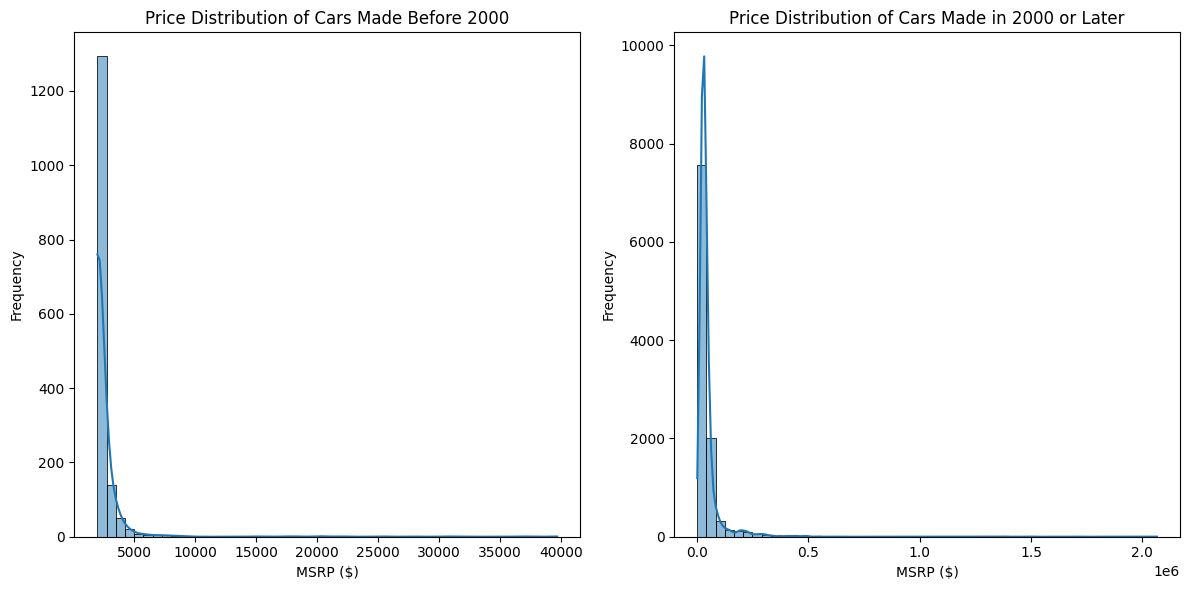

Average MSRP for cars made before 2000: $2481.34
Average MSRP for cars made in 2000 or later: $46248.38

Correlation matrix:
              MSRP       Age  is_newer
MSRP      1.000000 -0.227590  0.254537
Age      -0.227590  1.000000 -0.826124
is_newer  0.254537 -0.826124  1.000000


In [40]:
import seaborn as sns

# Create a new feature for Age
current_year = 2024
df['Age'] = current_year - df['Year']  # Assuming 'Year' is the column with the car's manufacturing year

# Create a binary feature indicating whether a car is newer (made in 2000 or later)
df['is_newer'] = (df['Year'] > 2000).astype(int)

# Visualize price distribution by year
plt.figure(figsize=(12, 6))

# Histogram for cars made before 2000
plt.subplot(1, 2, 1)
sns.histplot(df[df['Year'] < 2000]['MSRP'], bins=50, kde=True)
plt.title('Price Distribution of Cars Made Before 2000')
plt.xlabel('MSRP ($)')
plt.ylabel('Frequency')

# Histogram for cars made in 2000 or later
plt.subplot(1, 2, 2)
sns.histplot(df[df['Year'] >= 2000]['MSRP'], bins=50, kde=True)
plt.title('Price Distribution of Cars Made in 2000 or Later')
plt.xlabel('MSRP ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Analyze average prices
average_price_before_2000 = df[df['Year'] < 2000]['MSRP'].mean()
average_price_after_2000 = df[df['Year'] >= 2000]['MSRP'].mean()
print(f"Average MSRP for cars made before 2000: ${average_price_before_2000:.2f}")
print(f"Average MSRP for cars made in 2000 or later: ${average_price_after_2000:.2f}")

# Correlation analysis
correlation_matrix = df[['MSRP', 'Age', 'is_newer']].corr()
print("\nCorrelation matrix:")
print(correlation_matrix)


In [41]:
# Remove top and bottom 1% of MSRP values
#lower_bound = df['MSRP'].quantile(0.02)
#upper_bound = df['MSRP'].quantile(0.98)
#df = df[(df['MSRP'] >= lower_bound) & (df['MSRP'] <= upper_bound)]  # Keep only values excluding the top and bottom 1%

# Check the shape of the dataset after dropping outlier cars
print("\nShape of dataset after dropping outlier cars:")
print(df.shape)

# Removing outliers only affects the removal of exotic-rated cars, which have a very high correlation with price


Shape of dataset after dropping outlier cars:
(11914, 18)



Null values in each column:
Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
Age                     0
is_newer                0
dtype: int64

Percentage of null values in each column:
Make                  0.000000
Model                 0.000000
Year                  0.000000
Engine Fuel Type      0.025180
Engine HP             0.579151
Engine Cylinders      0.251805
Transmission Type     0.000000
Driven_Wheels         0.000000
Number of Doors       0.050361
Market Category      31.408427
Vehicle Size          0.000000
Vehicle Style         0.000000
highway MPG           0.000000
city mpg              0.000000
Popularity   

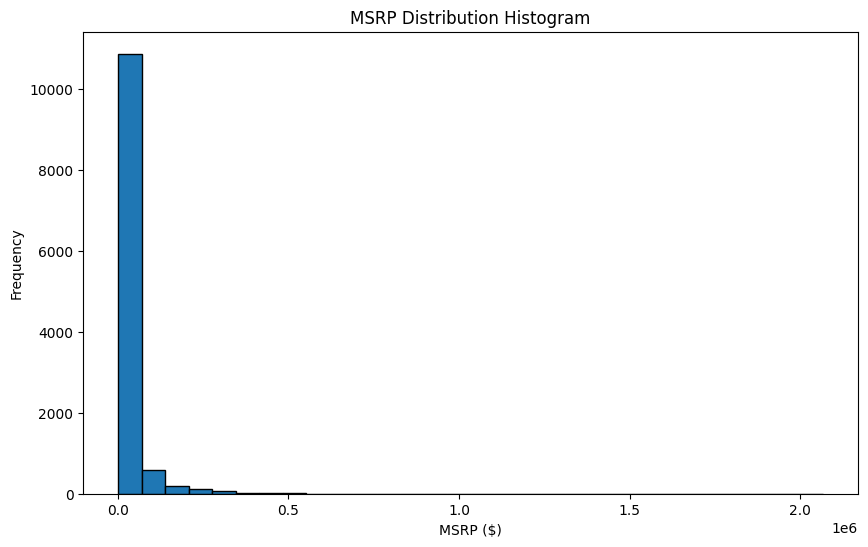

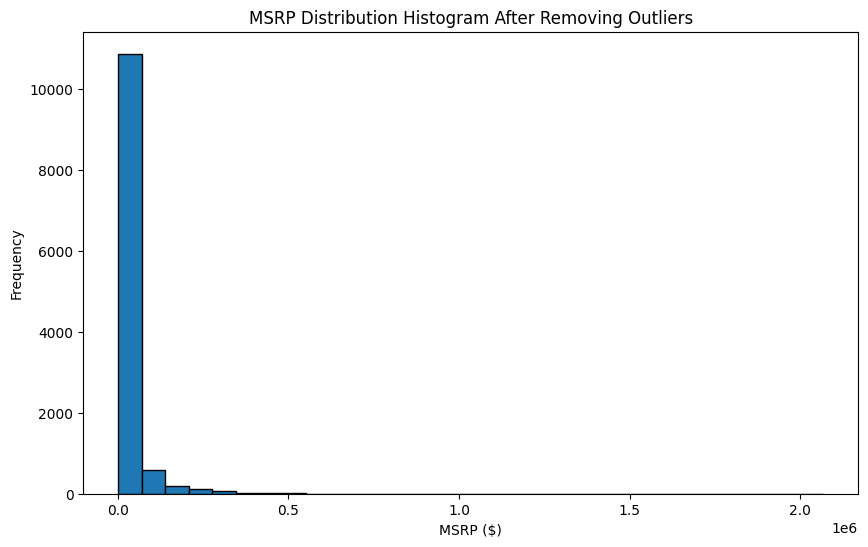


First few rows with new market category columns:
   Market_Flex_Fuel  Market_Luxury  Market_High-Performance  \
0                 0              1                        1   
1                 0              1                        0   
2                 0              1                        1   
3                 0              1                        0   
4                 0              1                        0   

   Market_Performance  Market_Exotic  Market_Hybrid  Market_Diesel  \
0                   1              0              0              0   
1                   1              0              0              0   
2                   1              0              0              0   
3                   1              0              0              0   
4                   0              0              0              0   

   Market_Crossover  Market_Factory_Tuner  Market_Hatchback  
0                 0                     1                 0  
1                 0       

In [42]:
# Check for null values in each column
print("\nNull values in each column:")
print(df.isnull().sum())

# Calculate percentage of null values in each column
print("\nPercentage of null values in each column:")
null_percentages = (df.isnull().sum() / len(df)) * 100
print(null_percentages)

# Identify columns with null values that need attention
columns_with_nulls = null_percentages[null_percentages > 0].index
print("\nColumns that contain null values:", list(columns_with_nulls))

# Analyze MSRP distribution before cleaning
print("\nMSRP Statistics before cleaning outliers:")
print(df['MSRP'].describe())

# Create a histogram to visualize MSRP distribution
plt.figure(figsize=(10, 6))
plt.hist(df['MSRP'], bins=30, edgecolor='black')
plt.title('MSRP Distribution Histogram')
plt.xlabel('MSRP ($)')
plt.ylabel('Frequency')
plt.show()


# Create a histogram to visualize the MSRP distribution after cleaning
plt.figure(figsize=(10, 6))
plt.hist(df['MSRP'], bins=30, edgecolor='black')
plt.title('MSRP Distribution Histogram After Removing Outliers')
plt.xlabel('MSRP ($)')
plt.ylabel('Frequency')
plt.show()

# Get unique categories from Market Category column
all_categories = set()
for categories in df['Market Category'].dropna().str.split(','):
    if categories is not None:
        all_categories.update(categories)

# Create new columns for each category
for category in all_categories:
    df[f'Market_{category.replace(" ", "_")}'] = df['Market Category'].fillna('').str.contains(category).astype(int)

# Drop original Market Category column
df = df.drop('Market Category', axis=1)

# Show the first few rows of the new category columns
print("\nFirst few rows with new market category columns:")
market_cols = [col for col in df.columns if col.startswith('Market_')]
print(df[market_cols].head())

# Print summary of the transformation
print("\nConclusion:")
print(f"1. Created {len(market_cols)} new binary columns for market categories")
print("2. Each column represents presence (1) or absence (0) of a category")
print("3. This transformation allows for better analysis of market category combinations")


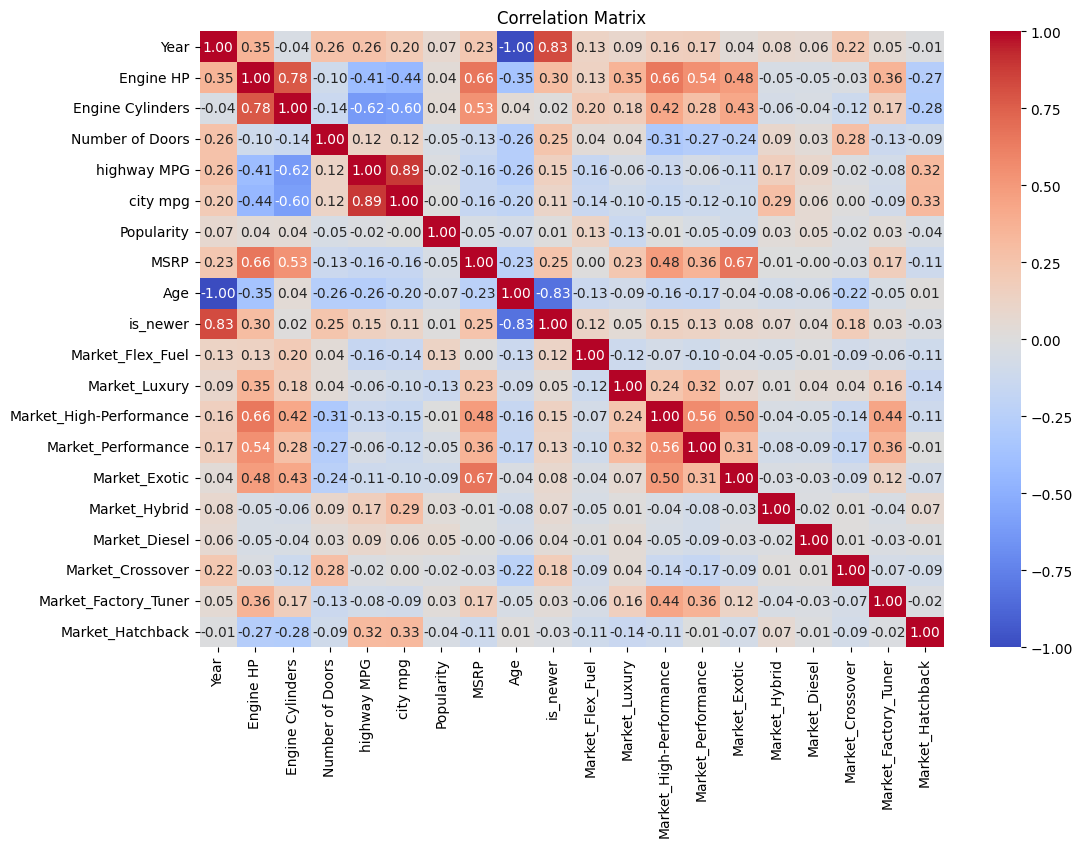

In [43]:

# Drop object columns from the DataFrame
df_numeric = df.select_dtypes(include=['number'])

# Correlation matrix
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

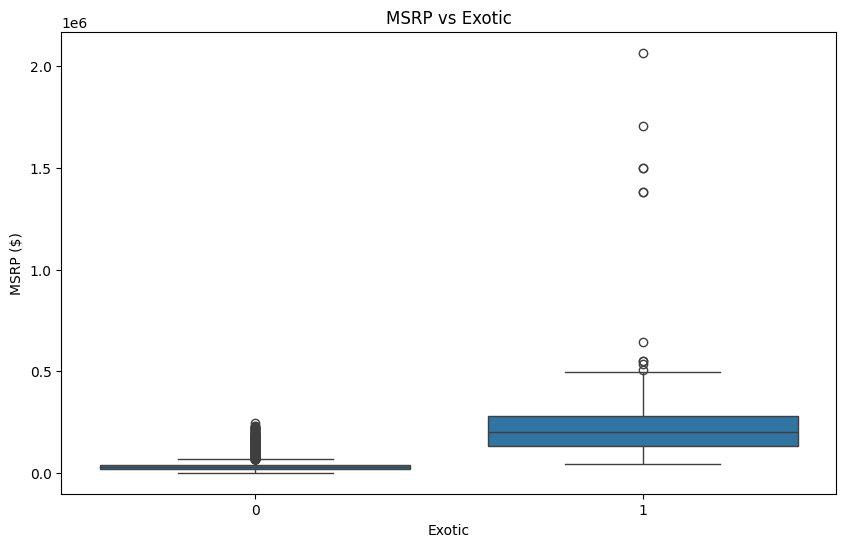

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Market_Exotic', y='MSRP', data=df)
plt.title('MSRP vs Exotic')
plt.xlabel('Exotic')
plt.ylabel('MSRP ($)')
plt.show()


# For MSRP overall, the correlation list is as follows:

1. Engine HP
2. Market_Exotic
3. Engine Cylinders
4. Year/Age/Is_newer
5. Market High Performance
6. Market Category Performance and High Performance

In [45]:
# Check for missing values in the dataframe
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])

# Drop rows with any NA values in the dataframe
df = df.dropna()

# Print updated info about the cleaned dataframe
print("\nCleaned dataframe:")
print(f"Shape after dropping rows with NA: {df.shape}")


Missing values in each column:
Engine Fuel Type     3
Engine HP           69
Engine Cylinders    30
Number of Doors      6
dtype: int64

Cleaned dataframe:
Shape after dropping rows with NA: (11812, 27)


In [46]:
print(df.describe())

               Year     Engine HP  Engine Cylinders  Number of Doors  \
count  11812.000000  11812.000000      11812.000000     11812.000000   
mean    2010.361581    249.504487          5.649424         3.432526   
std        7.594647    109.206947          1.751646         0.882919   
min     1990.000000     55.000000          0.000000         2.000000   
25%     2007.000000    170.000000          4.000000         2.000000   
50%     2015.000000    227.000000          6.000000         4.000000   
75%     2016.000000    300.000000          6.000000         4.000000   
max     2017.000000   1001.000000         16.000000         4.000000   

        highway MPG      city mpg    Popularity          MSRP           Age  \
count  11812.000000  11812.000000  11812.000000  1.181200e+04  11812.000000   
mean      26.320945     19.328141   1553.679902  4.055994e+04     13.638419   
std        7.443589      6.527734   1440.067820  6.028413e+04      7.594647   
min       12.000000      7.000000  

Data Cleaning and Type Conversion:

Before cleaning - Data types:
Make                        object
Model                       object
Year                         int64
Engine Fuel Type            object
Engine HP                  float64
Engine Cylinders           float64
Transmission Type           object
Driven_Wheels               object
Number of Doors            float64
Vehicle Size                object
Vehicle Style               object
highway MPG                  int64
city mpg                     int64
Popularity                   int64
MSRP                         int64
Age                          int64
is_newer                     int64
Market_Flex_Fuel             int64
Market_Luxury                int64
Market_High-Performance      int64
Market_Performance           int64
Market_Exotic                int64
Market_Hybrid                int64
Market_Diesel                int64
Market_Crossover             int64
Market_Factory_Tuner         int64
Market_Hatchback        

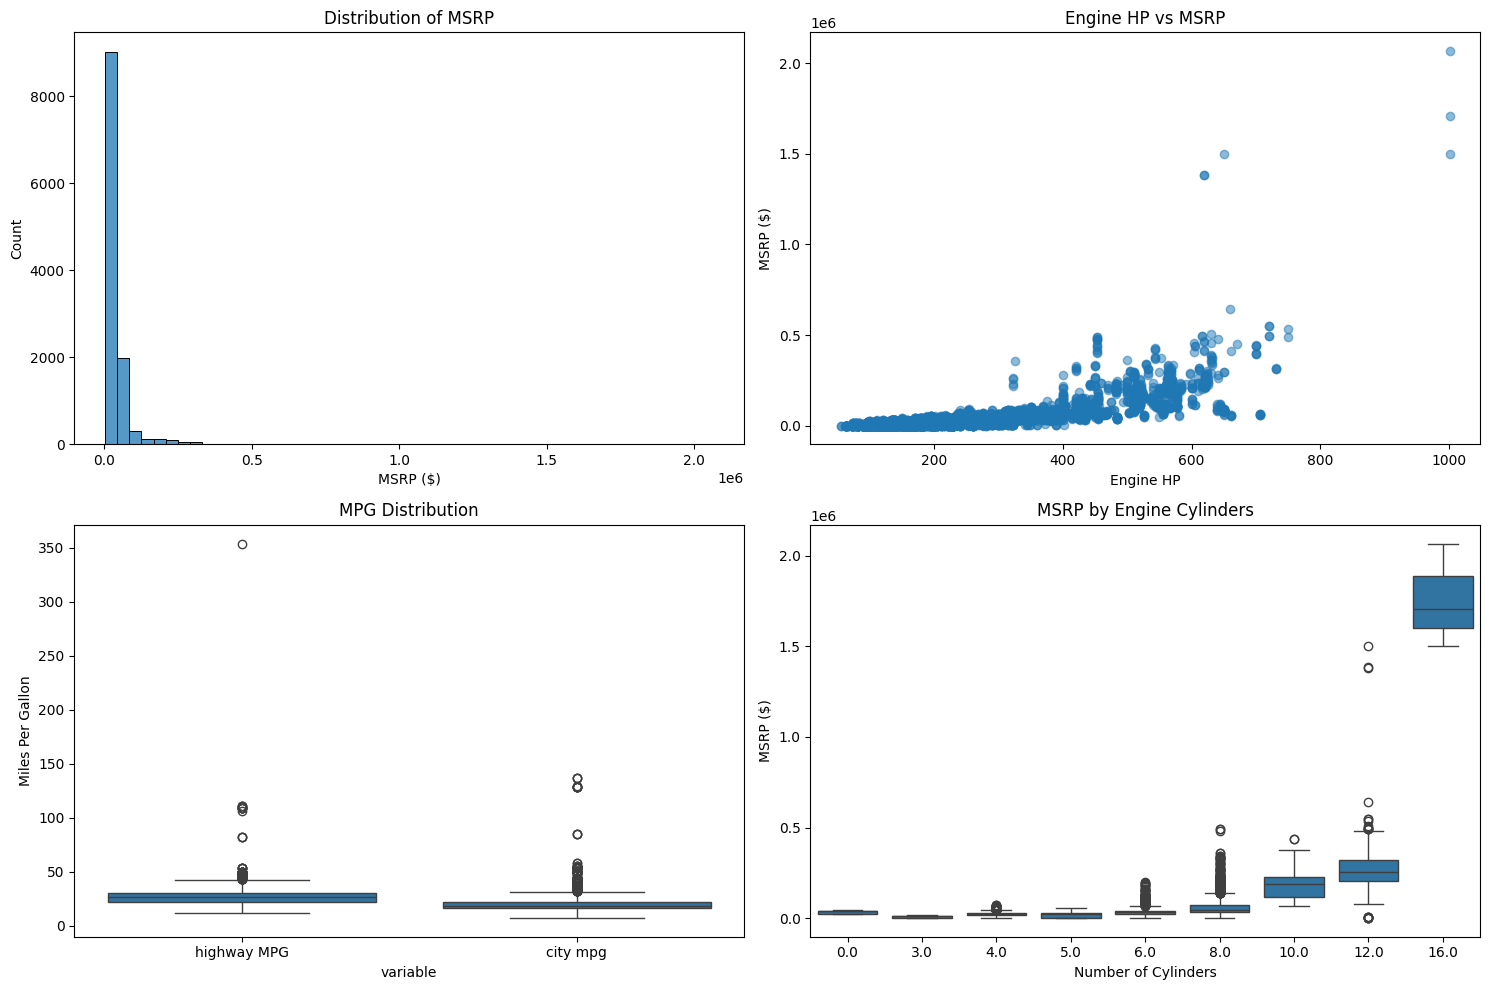

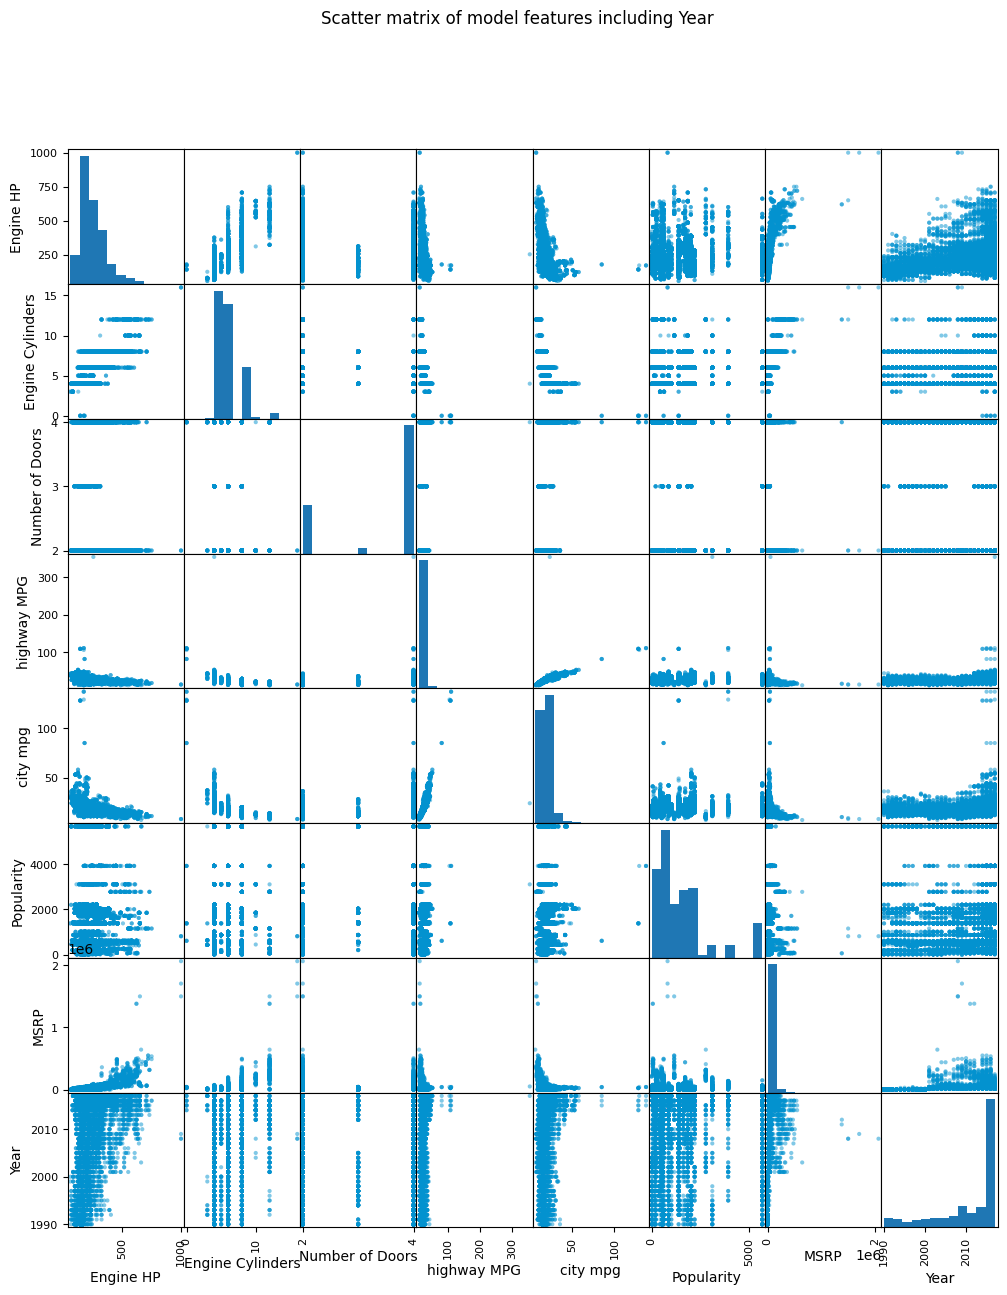

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Data Cleaning and Preprocessing
print("Data Cleaning and Type Conversion:")
print("\nBefore cleaning - Data types:")
print(df.dtypes)

# Convert numeric columns from object to float
numeric_columns = ['Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']
df[numeric_columns] = df[numeric_columns].astype(float)

print("\nAfter conversion - Data types:")
print(df.dtypes)

# Data Visualization
plt.figure(figsize=(15, 10))

# 1. Distribution of MSRP
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='MSRP', bins=50)
plt.title('Distribution of MSRP')
plt.xlabel('MSRP ($)')

# 2. Engine HP vs MSRP
plt.subplot(2, 2, 2)
plt.scatter(df['Engine HP'], df['MSRP'], alpha=0.5)
plt.title('Engine HP vs MSRP')
plt.xlabel('Engine HP')
plt.ylabel('MSRP ($)')

# 3. Box plot of MPG values
plt.subplot(2, 2, 3)
mpg_data = df[['highway MPG', 'city mpg']].melt()
sns.boxplot(data=mpg_data, x='variable', y='value')
plt.title('MPG Distribution')
plt.ylabel('Miles Per Gallon')

# 4. Engine Cylinders vs MSRP
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Engine Cylinders', y='MSRP')
plt.title('MSRP by Engine Cylinders')
plt.xlabel('Number of Cylinders')
plt.ylabel('MSRP ($)')

plt.tight_layout()
plt.show()

# Draw scatter matrix
# Since 'diagnosis' column is not present, we will use a placeholder for colors
# Define a default color for all points
default_color = '#0392cf'  # Using blue for all points

# Include 'Year' in the numeric columns for the scatter matrix
numeric_columns_with_year = numeric_columns + ['Year']

# Draw the scatter matrix only for numeric variables including Year
pd.plotting.scatter_matrix(df[numeric_columns_with_year], alpha=0.5, color=default_color, figsize=(12, 14), diagonal='hist', hist_kwds={'bins': 12})

# Add a title to the plot
plt.suptitle('Scatter matrix of model features including Year')

# Show the plot
plt.show()


We can see from the graphs a correlation between MSRP and Engine HP and Year.

This observation can guide further analysis and model selection.

In [48]:
from sklearn.model_selection import train_test_split

# Drop all string values from the DataFrame
df_numeric = df.select_dtypes(exclude=['object'])

df_numeric = df_numeric[['Engine HP', 'Age', 'Market_Luxury', 'Market_Performance', 'Market_Exotic', 'MSRP']]
# Define features and target variable
X = df_numeric[['Engine HP', 'Age', 'Market_Exotic', 'Market_Luxury', 'Market_Performance']]

y = df_numeric['MSRP']

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train/Test Split completed:")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

print(X)

Train/Test Split completed:
Training set size: 9449
Test set size: 2363
       Engine HP  Age  Market_Exotic  Market_Luxury  Market_Performance
0          335.0   13              0              1                   1
1          300.0   13              0              1                   1
2          300.0   13              0              1                   1
3          230.0   13              0              1                   1
4          230.0   13              0              1                   0
...          ...  ...            ...            ...                 ...
11909      300.0   12              0              1                   0
11910      300.0   12              0              1                   0
11911      300.0   12              0              1                   0
11912      300.0   11              0              1                   0
11913      221.0   18              0              1                   0

[11812 rows x 5 columns]


# Model 1 (Unedited)


Model 1 (Engine HP): MAE = 20352.860952177394, MSE = 986549581.5424501, R2 = 0.556269075065942


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


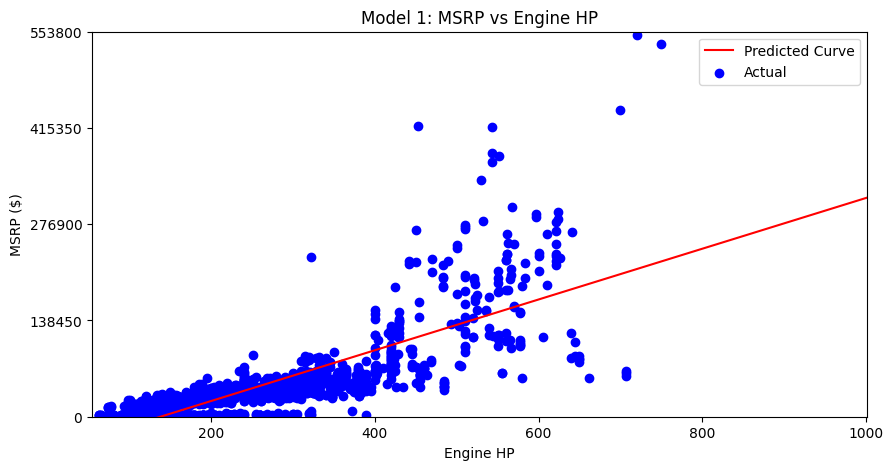

In [49]:
# Define features and target variable for the first model (using all data)
X1 = df_numeric[['Engine HP']]  # Use the entire dataset
y1 = df_numeric['MSRP']

# Train the first model directly on the data without replacing outliers
model1 = LinearRegression()
model1.fit(X1, y1)  # Fit the model using all data

# Predictions and evaluation for the first model
y_pred1 = model1.predict(X_test[['Engine HP']])  # Use the test set for predictions
mae1 = mean_absolute_error(y_test, y_pred1)  # Calculate MAE
mse1 = mean_squared_error(y_test, y_pred1)  # Calculate MSE
r2_1 = r2_score(y_test, y_pred1)  # Calculate R2 score

print(f"\nModel 1 (Engine HP): MAE = {mae1}, MSE = {mse1}, R2 = {r2_1}")

# Plotting the first model with prediction curve
plt.figure(figsize=(10, 5))
engine_hp_range = np.linspace(X1['Engine HP'].min(), X1['Engine HP'].max(), 100).reshape(-1, 1)
predicted_prices = model1.predict(engine_hp_range)

plt.plot(engine_hp_range, predicted_prices, color='red', label='Predicted Curve')
plt.scatter(X_test[['Engine HP']], y_test, color='blue', label='Actual')  # Use actual test data
plt.title('Model 1: MSRP vs Engine HP')
plt.xlabel('Engine HP')
plt.ylabel('MSRP ($)')
plt.xlim(left=X1['Engine HP'].min(), right=X1['Engine HP'].max())  # Set x-axis limit to the entire data
plt.ylim(bottom=0, top=y_test.max() + 5000)  # Adjust y-axis limit based on actual data
plt.yticks(np.linspace(0, y_test.max() + 5000, 5))  # Adjust y-ticks based on actual data
plt.legend()
plt.show()

# It is evident that there is a gap between prices, So to provide a more accurate pricing model, I'll split the dataset into cars that are younger than 23 Years. I'll drop the lower bound of cars, which are older than 23 years, as it looks like whatever the Engine condition, they are all in the same price; however, I'll keep the ones that have the Market_Exotic tag on

       Year  Engine HP  Engine Cylinders  Number of Doors  highway MPG  \
4228   2001      122.0               4.0              4.0         30.0   
11435  2001      200.0               6.0              4.0         22.0   
11434  2001      200.0               6.0              4.0         22.0   
11433  2001      200.0               6.0              3.0         22.0   
11432  2001      200.0               6.0              4.0         22.0   

       city mpg  Popularity     MSRP  Age  is_newer  Market_Flex_Fuel  \
4228       26.0       481.0  16699.0   23         1                 0   
11435      16.0      5657.0  33765.0   23         1                 0   
11434      16.0      5657.0  28595.0   23         1                 0   
11433      16.0      5657.0  22185.0   23         1                 0   
11432      16.0      5657.0  27435.0   23         1                 0   

       Market_Luxury  Market_High-Performance  Market_Performance  \
4228               0                        0  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


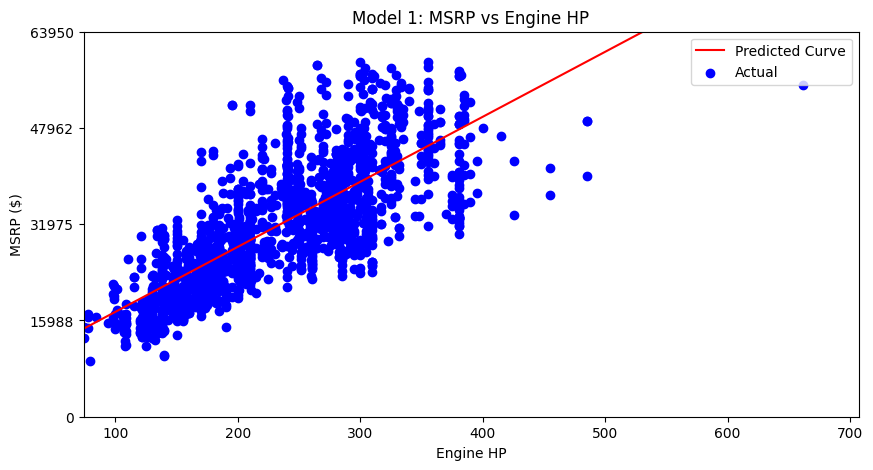

In [50]:
# Drop all string values from the DataFrame
df_numeric = df.select_dtypes(exclude=['object'])

# Filter out cars older than 22 years with Market_Exotic value of 1
df_numeric = df_numeric[df_numeric['Year'] > 2000]
df_numeric = df_numeric[df_numeric['Market_Exotic'] == 0]

# Filter out the top 5% of highest MSRP cars
threshold = df_numeric['MSRP'].quantile(0.90)
df_numeric = df_numeric[df_numeric['MSRP'] <= threshold]

print(df_numeric.sort_values(by='Year', ascending=True).head())

df_numeric = df_numeric[['Engine HP', 'Age', 'Market_Luxury', 'Market_Performance', 'Market_Exotic', 'MSRP']]
# Define features and target variable
X = df_numeric[['Engine HP', 'Age', 'Market_Exotic', 'Market_Luxury', 'Market_Performance']]

y = df_numeric['MSRP']

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define features and target variable for the first model (using all data)
X1 = df_numeric[['Engine HP']]  # Use the entire dataset
y1 = df_numeric['MSRP']

# Train the first model directly on the data without replacing outliers
model1 = LinearRegression()
model1.fit(X1, y1)  # Fit the model using all data

# Predictions and evaluation for the first model
y_pred1 = model1.predict(X_test[['Engine HP']])  # Use the test set for predictions
mae1 = mean_absolute_error(y_test, y_pred1)  # Calculate MAE
mse1 = mean_squared_error(y_test, y_pred1)  # Calculate MSE
r2_1 = r2_score(y_test, y_pred1)  # Calculate R2 score

print(f"\nModel 1 (Engine HP): MAE = {mae1}, MSE = {mse1}, R2 = {r2_1}")

# Plotting the first model with prediction curve
plt.figure(figsize=(10, 5))
engine_hp_range = np.linspace(X1['Engine HP'].min(), X1['Engine HP'].max(), 100).reshape(-1, 1)
predicted_prices = model1.predict(engine_hp_range)

plt.plot(engine_hp_range, predicted_prices, color='red', label='Predicted Curve')
plt.scatter(X_test[['Engine HP']], y_test, color='blue', label='Actual')  # Use actual test data
plt.title('Model 1: MSRP vs Engine HP')
plt.xlabel('Engine HP')
plt.ylabel('MSRP ($)')
plt.xlim(left=X1['Engine HP'].min(), right=X1['Engine HP'].max())  # Set x-axis limit to the entire data
plt.ylim(bottom=0, top=y_test.max() + 5000)  # Adjust y-axis limit based on actual data
plt.yticks(np.linspace(0, y_test.max() + 5000, 5))  # Adjust y-ticks based on actual data
plt.legend()
plt.show()

# Model 2


Model 2 (Age of the Car): MAE = 7858.337844682134, MSE = 94808554.77711843, R2 = 0.09484661992207066


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


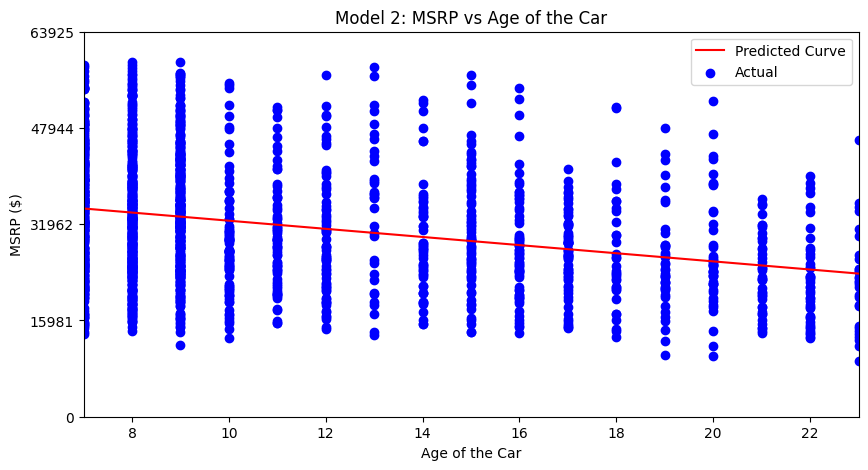

       Engine HP  Age  Market_Exotic  Market_Luxury  Market_Performance
10507      290.0    7              0              1                   0
7397       166.0    7              0              0                   0
11038      381.0    7              0              0                   0
1517       272.0    7              0              1                   1
3172       153.0    7              0              0                   0


In [51]:
# Define features and target variable for the second model (Age)
X2 = X_train[['Age']]  # Use the training set
y2 = y_train

# Train the second model using simple linear regression
model2 = LinearRegression()
model2.fit(X2, y2)

# Predictions and evaluation for the second model
y_pred2 = model2.predict(X_test[['Age']])  # Fix reference to X_test
mae2 = mean_absolute_error(y_test, y_pred2)  # Fix reference to y_test
mse2 = mean_squared_error(y_test, y_pred2)  # Fix reference to y_test
r2_2 = r2_score(y_test, y_pred2)  # Fix reference to y_test

print(f"\nModel 2 (Age of the Car): MAE = {mae2}, MSE = {mse2}, R2 = {r2_2}")

# Plotting the second model with prediction curve
plt.figure(figsize=(10, 5))
# Create a range of values for Age of the Car
age_range = np.linspace(X2['Age'].min(), X2['Age'].max(), 100).reshape(-1, 1)
predicted_prices_age = model2.predict(age_range)

plt.plot(age_range, predicted_prices_age, color='red', label='Predicted Curve')
plt.scatter(X_test[['Age']], y_test, color='blue', label='Actual')  # Fix reference to X_test and y_test
plt.title('Model 2: MSRP vs Age of the Car')
plt.xlabel('Age of the Car')
plt.ylabel('MSRP ($)')
plt.xlim(left=X2['Age'].min(), right=X2['Age'].max())  # Set x-axis limit to the minimum and maximum Age values
plt.ylim(bottom=0, top=y_train.max() + 5000)  # Fix reference to y_train
plt.yticks(np.linspace(0, y_train.max() + 5000, 5))  # Fix reference to y_train
plt.legend()
plt.show()

print(X_train.sort_values(by='Age', ascending=True).head())

# Model 3

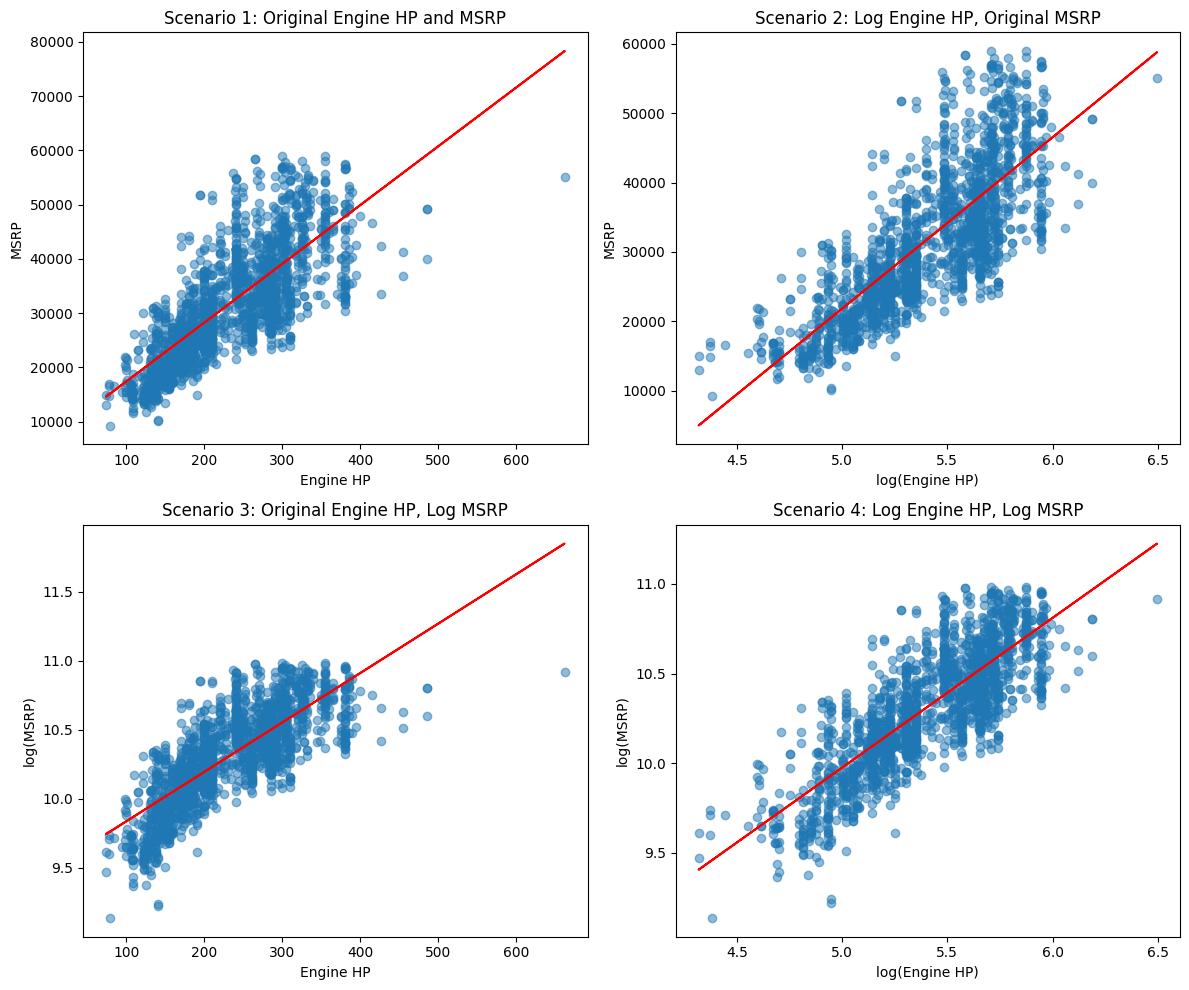

                        Scenario   Coefficient      Intercept           MSE  \
0      Original Engine HP & MSRP    108.327274    6588.907947  4.375228e+07   
1  Log Engine HP & Original MSRP  24689.375885 -101615.488165  4.206030e+07   
2  Original Engine HP & Log MSRP      0.003577       9.480130  4.408234e-02   
3       Log Engine HP & Log MSRP      0.834134       5.805331  3.887911e-02   

         R2  
0  0.582290  
1  0.598443  
2  0.608348  
3  0.654576  


In [52]:
from sklearn.metrics import mean_squared_error, r2_score

# Use the training set for Engine HP
X3 = X_train[['Engine HP']]
y3 = y_train

# Scenario 1: Original form of both Engine HP and MSRP
model1 = LinearRegression()
model1.fit(X3, y3)  # Fit model using only Engine HP
y1_pred = model1.predict(X_test[['Engine HP']])  # Predict using Engine HP
mse1 = mean_squared_error(y_test, y1_pred)
r2_1 = r2_score(y_test, y1_pred)

# Scenario 2: Log form of Engine HP, original form of MSRP
X2_train = np.log(X3 + 1)  # Adding 1 to avoid log(0)
X2_test = np.log(X_test[['Engine HP']] + 1)
model2 = LinearRegression()
model2.fit(X2_train, y3)
y2_pred = model2.predict(X2_test)
mse2 = mean_squared_error(y_test, y2_pred)
r2_2 = r2_score(y_test, y2_pred)

# Scenario 3: Original form of Engine HP, log form of MSRP
y3_train = np.log(y3)
y3_test = np.log(y_test)
model3 = LinearRegression()
model3.fit(X3, y3_train)
y3_pred = model3.predict(X_test[['Engine HP']])
mse3 = mean_squared_error(y3_test, y3_pred)
r2_3 = r2_score(y3_test, y3_pred)

# Scenario 4: Log form of both Engine HP and MSRP
model4 = LinearRegression()
model4.fit(X2_train, y3_train)
y4_pred = model4.predict(X2_test)
mse4 = mean_squared_error(y3_test, y4_pred)
r2_4 = r2_score(y3_test, y4_pred)

# Prepare to plot the results for each scenario
plt.figure(figsize=(12, 10))

# Scenario 1 plot
plt.subplot(2, 2, 1)
plt.scatter(X_test[['Engine HP']], y_test, alpha=0.5)
plt.plot(X_test[['Engine HP']], y1_pred, color='red')
plt.title('Scenario 1: Original Engine HP and MSRP')
plt.xlabel('Engine HP')
plt.ylabel('MSRP')

# Scenario 2 plot
plt.subplot(2, 2, 2)
plt.scatter(X2_test, y_test, alpha=0.5)
plt.plot(X2_test, y2_pred, color='red')
plt.title('Scenario 2: Log Engine HP, Original MSRP')
plt.xlabel('log(Engine HP)')
plt.ylabel('MSRP')

# Scenario 3 plot
plt.subplot(2, 2, 3)
plt.scatter(X_test[['Engine HP']], y3_test, alpha=0.5)
plt.plot(X_test[['Engine HP']], y3_pred, color='red')
plt.title('Scenario 3: Original Engine HP, Log MSRP')
plt.xlabel('Engine HP')
plt.ylabel('log(MSRP)')

# Scenario 4 plot
plt.subplot(2, 2, 4)
plt.scatter(X2_test, y3_test, alpha=0.5)
plt.plot(X2_test, y4_pred, color='red')
plt.title('Scenario 4: Log Engine HP, Log MSRP')
plt.xlabel('log(Engine HP)')
plt.ylabel('log(MSRP)')

plt.tight_layout()
plt.show()

# Display coefficients, MSE, and R2 for each scenario
coef_intercepts_mse_r2 = {
    'Scenario': ['Original Engine HP & MSRP', 'Log Engine HP & Original MSRP', 'Original Engine HP & Log MSRP', 'Log Engine HP & Log MSRP'],
    'Coefficient': [model1.coef_[0], model2.coef_[0], model3.coef_[0], model4.coef_[0]],
    'Intercept': [model1.intercept_, model2.intercept_, model3.intercept_, model4.intercept_],
    'MSE': [mse1, mse2, mse3, mse4],
    'R2': [r2_1, r2_2, r2_3, r2_4]
}

coef_df_sample = pd.DataFrame(coef_intercepts_mse_r2)
print(coef_df_sample)


# Evidently, Scenario 4 is the best to look at

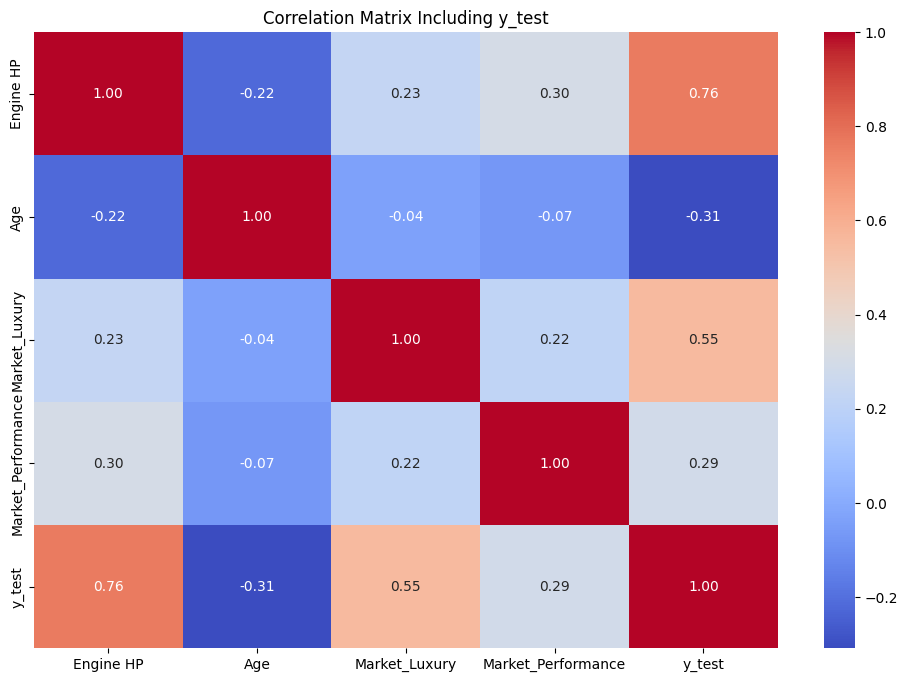

In [53]:
# Drop object columns from the DataFrame
correlation_X_test = X_test.select_dtypes(include=['number'])
correlation_X_test = correlation_X_test[['Engine HP', 'Age', 'Market_Luxury', 'Market_Performance']]
correlation_Y_test = y_test.values  # Ensure y_test is in a compatible format

# Combine X_test and y_test for correlation analysis
correlation_data = correlation_X_test.copy()
correlation_data['y_test'] = correlation_Y_test

# Correlation matrix
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Including y_test')
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Forward variable selection function
def forward_selection(X_train, X_test, y_train, y_test):
    initial_features = []  # Start with no features
    remaining_features = [feature for feature in X_train.columns if feature != 'Market_Exotic']  # Exclude 'Market_Exotic'
    best_features = []
    best_mae, best_mse, best_r2 = np.inf, np.inf, -np.inf

    # Initialize variables to store best model performance
    final_mae, final_mse, final_r2 = None, None, None

    while remaining_features:
        mae_list, mse_list, r2_list = [], [], []
        model_list = []

        for feature in remaining_features:
            # Try the current feature along with the already selected features
            features_to_try = initial_features + [feature]

            # Train the model on the selected features
            model = LinearRegression()
            model.fit(X_train[features_to_try], y_train)

            # Make predictions
            y_pred = model.predict(X_test[features_to_try])

            # Evaluate performance
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            mae_list.append((feature, mae))
            mse_list.append((feature, mse))
            r2_list.append((feature, r2))
            model_list.append((model, features_to_try))  # Store model and corresponding features

        # Find the best feature to add based on R² score
        best_feature_r2 = max(r2_list, key=lambda x: x[1])  # Highest R²
        best_feature_mae = min(mae_list, key=lambda x: x[1])  # Lowest MAE
        best_feature_mse = min(mse_list, key=lambda x: x[1])  # Lowest MSE

        # Add the best feature to the model
        best_features.append(best_feature_r2[0])
        initial_features.append(best_feature_r2[0])
        remaining_features.remove(best_feature_r2[0])

        # Update the best performance
        best_mae, best_mse, best_r2 = best_feature_mae[1], best_feature_mse[1], best_feature_r2[1]

        # Retrieve the model with the best R² and corresponding features
        best_model, best_features_to_try = model_list[r2_list.index(best_feature_r2)]

        # Print the model's coefficients for the selected features
        coef = best_model.coef_
        intercept = best_model.intercept_
        coef_list = zip(best_features_to_try, coef)

        print(f"Added Feature: {best_feature_r2[0]}")
        print(f"Current Model Features: {best_features_to_try}")
        print(f"Current Coefficients: {[f'{feature}: {coef_value:.4f}' for feature, coef_value in coef_list]}")
        print(f"Intercept: {intercept:.4f}")
        print(f"Current MAE: {best_mae:.2f}, MSE: {best_mse:.2f}, R²: {best_r2:.2f}")
        print("-" * 50)

        # Store the final best evaluation
        final_mae, final_mse, final_r2 = best_mae, best_mse, best_r2

    print("\nFinal Model Features:", best_features)
    print(f"Final MAE: {final_mae:.2f}, MSE: {final_mse:.2f}, R²: {final_r2:.2f}")


# Remove rows with missing values
df_sample = df_numeric.dropna()
print("Number of Observations after removing missing values:",df_sample.shape[0])


# Choose features that we would like to explore
X = df_sample.drop(columns=['MSRP'])  # X contains all columns except 'medv'
y = df_sample['MSRP']  # The dependent variable 'medv'

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Now you can run the forward selection with this data
forward_selection(X_train, X_test, y_train, y_test)


Number of Observations after removing missing values: 8708
Added Feature: Engine HP
Current Model Features: ['Engine HP']
Current Coefficients: ['Engine HP: 108.9845']
Intercept: 6415.7635
Current MAE: 5129.41, MSE: 44230246.11, R²: 0.57
--------------------------------------------------
Added Feature: Market_Luxury
Current Model Features: ['Engine HP', 'Market_Luxury']
Current Coefficients: ['Engine HP: 92.9274', 'Market_Luxury: 10304.0401']
Intercept: 7911.6551
Current MAE: 4126.72, MSE: 28121435.27, R²: 0.73
--------------------------------------------------
Added Feature: Age
Current Model Features: ['Engine HP', 'Market_Luxury', 'Age']
Current Coefficients: ['Engine HP: 88.8795', 'Market_Luxury: 10249.4404', 'Age: -338.4517']
Intercept: 12685.6267
Current MAE: 3974.74, MSE: 25904302.33, R²: 0.75
--------------------------------------------------
Added Feature: Market_Performance
Current Model Features: ['Engine HP', 'Market_Luxury', 'Age', 'Market_Performance']
Current Coefficient

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Backward variable selection function adapted to the model
def backward_selection(X_train, X_test, y_train, y_test):
    # Ensure X_train and X_test are DataFrames
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    # Start with all features in the model, excluding 'Market_Exotic'
    best_features = [feature for feature in X_train.columns if feature != 'Market_Exotic']

    while len(best_features) > 1:  # Ensure at least one feature remains
        # Train the model with the current set of features
        model = LinearRegression()
        model.fit(X_train[best_features], y_train)  # Fit model using current best features

        # Make predictions
        y_pred = model.predict(X_test[best_features])  # Predict using the same features

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Print results for the current set of features
        print(f"Remaining Features: {best_features}")
        print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")
        print("-" * 50)

        # Try removing one feature at a time and find the one that decreases R² the least
        worst_r2 = float('inf')
        feature_to_remove = None

        for feature in best_features:
            features_to_try = [f for f in best_features if f != feature]
            # Train the model without the current feature
            model.fit(X_train[features_to_try], y_train)
            y_pred_try = model.predict(X_test[features_to_try])
            r2_try = r2_score(y_test, y_pred_try)

            # Find the feature whose removal leads to the least decrease in R²
            if r2_try < worst_r2:
                worst_r2 = r2_try
                feature_to_remove = feature

        # Remove the feature that results in the least reduction in performance
        if feature_to_remove:
            best_features.remove(feature_to_remove)
            print(f"Removed Feature: {feature_to_remove}")
            print("-" * 50)

    # If only one feature remains, print the final evaluation
    if len(best_features) == 1:
        print(f"Final Remaining Feature: {best_features}")
        model.fit(X_train[best_features], y_train)
        y_pred = model.predict(X_test[best_features])
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Final Model with One Feature: {best_features}")
        print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")
        print("-" * 50)

# Example usage: Perform backward selection
# Ensure that X_train, X_test, y_train, and y_test are already defined, similar to forward selection.

backward_selection(X_train, X_test, y_train, y_test)


Remaining Features: ['Engine HP', 'Age', 'Market_Luxury', 'Market_Performance']
MAE: 3975.96, MSE: 25878751.96, R²: 0.75
--------------------------------------------------
Removed Feature: Engine HP
--------------------------------------------------
Remaining Features: ['Age', 'Market_Luxury', 'Market_Performance']
MAE: 6228.25, MSE: 60464714.37, R²: 0.42
--------------------------------------------------
Removed Feature: Market_Luxury
--------------------------------------------------
Remaining Features: ['Age', 'Market_Performance']
MAE: 7627.43, MSE: 86436755.61, R²: 0.16
--------------------------------------------------
Removed Feature: Age
--------------------------------------------------
Final Remaining Feature: ['Market_Performance']
Final Model with One Feature: ['Market_Performance']
MAE: 7992.81, MSE: 94496566.31, R²: 0.09
--------------------------------------------------


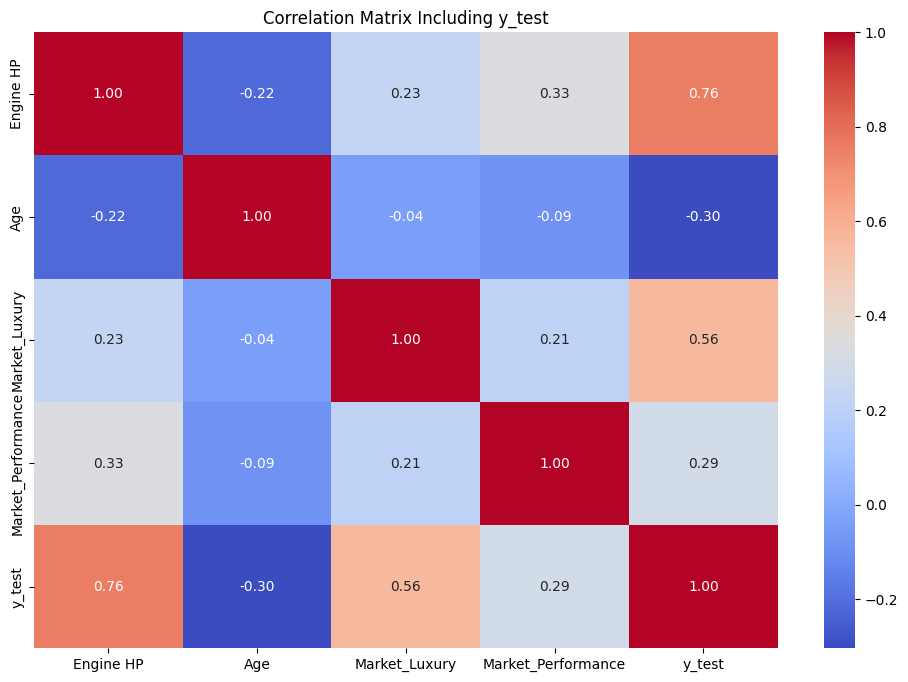

In [56]:
# Drop object columns from the DataFrame
correlation_X_test = X_test.select_dtypes(include=['number'])
correlation_X_test = correlation_X_test[['Engine HP', 'Age', 'Market_Luxury', 'Market_Performance']]
correlation_Y_test = y_test.values  # Ensure y_test is in a compatible format

# Combine X_test and y_test for correlation analysis
correlation_data = correlation_X_test.copy()
correlation_data['y_test'] = correlation_Y_test

# Correlation matrix
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Including y_test')
plt.show()

In [57]:
# Define the final set of predictors based on previous analysis
# Since best_features has not been defined, we will define it as an empty list for now
best_features = []  # Placeholder for final selected features

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Remove rows with missing values
df_sample = df_numeric.dropna()
print("Number of Observations after removing missing values:", df_sample.shape[0])

# Choose specific features for testing
X = df_sample[['Engine HP', 'Age', 'Market_Luxury', 'Market_Performance']]  # Selected features
y = df_sample['MSRP']  # The dependent variable 'MSRP'

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Forward variable selection function
def forward_selection(X_train, X_test, y_train, y_test):
    initial_features = []  # Start with no features
    remaining_features = list(X_train.columns)  # All features that haven't been selected
    best_mae, best_mse, best_r2 = np.inf, np.inf, -np.inf

    # Initialize variables to store best model performance
    final_mae, final_mse, final_r2 = None, None, None

    while remaining_features:
        mae_list, mse_list, r2_list = [], [], []
        model_list = []

        for feature in remaining_features:
            # Try the current feature along with the already selected features
            features_to_try = initial_features + [feature]

            # Train the model on the selected features
            model = LinearRegression()
            model.fit(X_train[features_to_try], y_train)

            # Make predictions
            y_pred = model.predict(X_test[features_to_try])

            # Evaluate performance
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            mae_list.append((feature, mae))
            mse_list.append((feature, mse))
            r2_list.append((feature, r2))
            model_list.append((model, features_to_try))  # Store model and corresponding features

        # Find the best feature to add based on R² score
        best_feature_r2 = max(r2_list, key=lambda x: x[1])  # Highest R²
        best_feature_mae = min(mae_list, key=lambda x: x[1])  # Lowest MAE
        best_feature_mse = min(mse_list, key=lambda x: x[1])  # Lowest MSE

        # Add the best feature to the model
        best_features.append(best_feature_r2[0])
        initial_features.append(best_feature_r2[0])
        remaining_features.remove(best_feature_r2[0])

        # Update the best performance
        best_mae, best_mse, best_r2 = best_feature_mae[1], best_feature_mse[1], best_feature_r2[1]

        # Retrieve the model with the best R² and corresponding features
        best_model, best_features_to_try = model_list[r2_list.index(best_feature_r2)]

        # Print the model's coefficients for the selected features
        coef = best_model.coef_
        intercept = best_model.intercept_
        coef_list = zip(best_features_to_try, coef)

        print(f"Added Feature: {best_feature_r2[0]}")
        print(f"Current Model Features: {best_features_to_try}")
        print(f"Current Coefficients: {[f'{feature}: {coef_value:.4f}' for feature, coef_value in coef_list]}")
        print(f"Intercept: {intercept:.4f}")
        print(f"Current MAE: {best_mae:.2f}, MSE: {best_mse:.2f}, R²: {best_r2:.2f}")
        print("-" * 50)

        # Store the final best evaluation
        final_mae, final_mse, final_r2 = best_mae, best_mse, best_r2

    print("\nFinal Model Features:", best_features)
    print(f"Final MAE: {final_mae:.2f}, MSE: {final_mse:.2f}, R²: {final_r2:.2f}")

# Now you can run the forward selection with this data
forward_selection(X_train, X_test, y_train, y_test)

print(best_features)


Number of Observations after removing missing values: 8708
Added Feature: Engine HP
Current Model Features: ['Engine HP']
Current Coefficients: ['Engine HP: 108.9845']
Intercept: 6415.7635
Current MAE: 5129.41, MSE: 44230246.11, R²: 0.57
--------------------------------------------------
Added Feature: Market_Luxury
Current Model Features: ['Engine HP', 'Market_Luxury']
Current Coefficients: ['Engine HP: 92.9274', 'Market_Luxury: 10304.0401']
Intercept: 7911.6551
Current MAE: 4126.72, MSE: 28121435.27, R²: 0.73
--------------------------------------------------
Added Feature: Age
Current Model Features: ['Engine HP', 'Market_Luxury', 'Age']
Current Coefficients: ['Engine HP: 88.8795', 'Market_Luxury: 10249.4404', 'Age: -338.4517']
Intercept: 12685.6267
Current MAE: 3974.74, MSE: 25904302.33, R²: 0.75
--------------------------------------------------
Added Feature: Market_Performance
Current Model Features: ['Engine HP', 'Market_Luxury', 'Age', 'Market_Performance']
Current Coefficient

# Conclusion: I am satisfied with the final model’s performance.


In [58]:
# Check if any features were selected before proceeding
if best_features:
    # Train the final model with the selected features
    model = LinearRegression()  # Initialize the model
    model.fit(X_train[best_features], y_train)
    y_pred_final = model.predict(X_test[best_features])

    # Calculate evaluation metrics
    mae_final = mean_absolute_error(y_test, y_pred_final)
    mse_final = mean_squared_error(y_test, y_pred_final)
    r2_final = r2_score(y_test, y_pred_final)

    # Print the results
    print(f"Final Model with Selected Features: {best_features}")
    print(f"MAE: {mae_final:.2f}, MSE: {mse_final:.2f}, R²: {r2_final:.2f}")
    print("-" * 50)

    # Conclusion
    if r2_final > 0.7:
        satisfaction = "satisfied"
    else:
        satisfaction = "not satisfied"

    print(f"Conclusion: I am {satisfaction} with the final model’s performance.")
    print("Next Steps: Consider exploring additional features or using more complex models.")
    print("If I could do something differently, I would conduct more thorough feature engineering.")
    print("To business leadership: Focus on the key predictors identified and their impact on the target variable.")
else:
    print("No features were selected for the final model.")

Final Model with Selected Features: ['Engine HP', 'Market_Luxury', 'Age', 'Market_Performance']
MAE: 3975.96, MSE: 25878751.96, R²: 0.75
--------------------------------------------------
Conclusion: I am satisfied with the final model’s performance.
Next Steps: Consider exploring additional features or using more complex models.
If I could do something differently, I would conduct more thorough feature engineering.
To business leadership: Focus on the key predictors identified and their impact on the target variable.


# Are you satisfied with your final model’s performance?  Why or why not?

## Satisfaction with Model Performance

I would say that I am generally satisfied with the final model's performance for the following reasons:
1. R² Value: An R² of 0.75 indicates that the model explains 75% of the variance in the target variable (MSRP). This is a strong indication that the model captures a significant amount of the underlying patterns in the data.

2. Error Metrics: The MAE of approximately $3976 suggests that, on average, the model's predictions are within this range of the actual prices. This level of accuracy can be acceptable depending on the context of the application, especially in the automotive market where prices can vary widely.

3. Feature Selection: The model utilizes relevant features such as 'Engine HP', 'Market_Luxury', 'Age', and 'Market_Performance', which are likely to have a meaningful impact on car pricing. This suggests that the model is built on a solid foundation of important predictors.

## Areas for Improvement
However, there are also areas for potential improvement:
1. MAE and MSE Values: While the MAE is reasonable, there is always room for improvement. Exploring additional features or more complex models could help reduce these error metrics further.
2. Feature Engineering: As you mentioned, conducting more thorough feature engineering could uncover additional insights and improve model performance. This could involve creating interaction terms, polynomial features, or using domain knowledge to derive new features.
3. Model Complexity: Depending on the business requirements, it might be beneficial to explore more complex models (e.g., ensemble methods, neural networks) that could capture non-linear relationships in the data.


# Next Steps

1. Feature Engineering: 

- Create Interaction Terms: Explore interactions between features (e.g., Engine HP and Market_Luxury) to capture more complex relationships.
- Polynomial Features: Consider adding polynomial features for continuous variables to capture non-linear relationships.
- Domain-Specific Features: Utilize domain knowledge to create new features that may influence car pricing, such as Age squared or Engine HP divided by Weight.

2. Data Exploration and Cleaning:

- Handle Missing Values: Revisit the handling of missing values to ensure no important data is lost. Consider imputation techniques or using models that can handle missing data.
- Outlier Analysis: Conduct a thorough analysis of outliers to determine if they should be removed or treated differently, as they can skew model performance.

3. Model Selection and Evaluation:

- Try Different Algorithms: Experiment with various regression algorithms, such as:
Ridge and Lasso Regression: To handle multicollinearity and perform feature selection.
- Decision Trees and Random Forests: To capture non-linear relationships and interactions without extensive feature engineering.
- Gradient Boosting Machines (GBM): For improved accuracy through ensemble learning.
- Cross-Validation: Implement k-fold cross-validation to ensure the model's robustness and to avoid overfitting.

4. Hyperparameter Tuning:

- Optimize Model Parameters: Use techniques like Grid Search or Random Search to find the best hyperparameters for your chosen models.

5. Model Interpretation:

- Feature Importance Analysis: Analyze which features contribute most to the predictions. This can help in understanding the model and communicating results to stakeholders.

# What would I do differently if I could?

If I could, I would separate further the datapoints; there is a lot of varaibility which has been needed to been cut out because some outliers play against the EDA, such as exotic cars being in the dataset, or cars that are older than the 2000's. If I had more Domain Knowledge, I would probably know what else I might be missing, maybe also add a state of the car, as some cars are better taken care of than others. 

# Based on your findings, what would you want to communicate to business leadership in this industry?

## Key Insights and Recommendations

1. **Engine HP and Pricing**:
    - There is a strong positive correlation between Engine HP and MSRP. Higher horsepower generally leads to higher prices. This suggests that performance features are a significant driver of car prices.

2. **Market Segments**:
    - Luxury and Performance market segments also show a strong correlation with MSRP. Vehicles categorized under these segments tend to have higher prices. This indicates that branding and market positioning play crucial roles in pricing strategies.

3. **Age of the Car**:
    - The age of the car negatively correlates with MSRP. Newer cars are priced higher, which is expected. This highlights the importance of keeping the inventory updated with newer models to maintain higher price points.

4. **Outliers and Market Trends**:
    - Exotic cars and outliers significantly impact the overall pricing model. While these cars represent a small portion of the market, they can skew the data. It is essential to consider these factors when analyzing market trends and making pricing decisions. Exotic cars, while not taken into account for pricing, have a massive leverage on price, so they should not be overlooked. Always look for exotic cars, be it old or new.

## Strategic Recommendations

1. **Focus on Performance and Luxury Features**:
    - Invest in enhancing the quantity in performance and luxury features for newer models. These attributes are highly valued by consumers and can justify higher price points.

2. **Update Inventory Regularly**:
    - Ensure that the inventory is regularly updated with newer models. Older models should be phased out to make room for new arrivals, maintaining a premium pricing strategy.

3. **Targeted Marketing**:
    - Develop targeted marketing campaigns for luxury and performance segments. Highlighting these features can attract high-end customers willing to pay a premium.

4. **Data-Driven Pricing Strategies**:
    - Utilize data analytics to continuously monitor market trends and adjust pricing strategies accordingly. This will help in staying competitive and maximizing revenue.

5. **Consideration of Outliers**:
    - While exotic cars and outliers are part of the market, they should be analyzed separately to avoid skewing the overall pricing model. Special strategies can be developed for these niche segments.

By focusing on these key areas, business leadership can make informed decisions that align with market demands and drive profitability.
